In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext dotenv
%dotenv ../.env

In [3]:
cnx = create_engine(os.getenv('EDMDB'))

#### PLUTO and building footprints comparison. Create supporting dataframes

Create dataframes of bldgclass and landuse definitions

In [4]:
bldgclass_def = pd.read_sql_query('''SELECT * FROM dcp.bldgclass_definitions;''', cnx)
landuse_def = pd.read_sql_query('''SELECT * FROM dcp.landuse_definitions;''', cnx)
landuse_def

,landuse,def
0,01,One and Two Family Buildings
1,02,Multi-Family Walkup Buildings
2,03,Multi-Family Elevator Buildings
3,04,Mixed Residential and Commercial
4,05,Commercial and Office
5,06,Industrial and Manufacturing
6,07,Transportation and Utility
7,08,Public Facilities and Institutions
8,09,Open Space and Outdoor Recreation
9,10,Parking Facilities


Create a dataframe containing NUMBLDGS for all PLUTO records for future queries

In [5]:
pluto = pd.read_sql_query('''SELECT CAST("BBL" AS TEXT), "Borough", "NumBldgs" FROM dcp.pluto202;''', cnx)
pluto.head()

,BBL,Borough,NumBldgs
0,3008340046,BK,1.0
1,4040420106,QN,2.0
2,3046790017,BK,2.0
3,3078310006,BK,1.0
4,3078310007,BK,1.0


Find lots where building footprints does not have the same number of buildings as PLUTO.

In [6]:
df = pd.read_sql_query('''WITH footprints_count_by_bbl AS (
	SELECT mpluto_bbl,
	COUNT(*) AS bldg_footprints_count
	FROM dcp.bldg_footprints
	GROUP BY mpluto_bbl
)
SELECT CAST("BBL" AS TEXT),
"Borough",
"Address", 
"LandUse",
"BldgClass",
"OwnerName",
"NumBldgs",
bldg_footprints_count, 
"NumBldgs" - bldg_footprints_count AS difference
FROM dcp.pluto202, footprints_count_by_bbl
WHERE "BBL" = CAST(mpluto_bbl AS NUMERIC)
AND "NumBldgs" <> bldg_footprints_count
ORDER BY difference DESC;''', cnx)
df.head()

,BBL,Borough,Address,LandUse,BldgClass,OwnerName,NumBldgs,bldg_footprints_count,difference
0,4163500300,QN,202-30 ROCKAWAY POINT BLVD,01,A8,BREEZY POINT COOPERA,795,518,277
1,4142600001,QN,154-68 BROOKVILLE BOULEVARD,07,T1,PORT AUTHORITY OF NY AND NJ,422,246,176
2,4163500400,QN,217-02 BREEZY POINT BLVD,01,A8,"BREEZY POINT COOPERATIVE, INC",1867,1720,147
3,4163400050,QN,1 ROCKAWAY POINT BLVD,01,A8,BREEZY POINT CO-OP,518,404,114
4,5054607501,SI,4219A AMBOY ROAD,02,R3,AVON AT GREAT KILLS CONDOMINIUM,63,9,54


#### Questions

How many lots have differences in counts?

In [7]:
df.shape[0]

20797

How often does PLUTO have greater numbers?

In [8]:
more_bldgs_on_pluto = df[(df['NumBldgs'] > df['bldg_footprints_count'])]
more_bldgs_on_pluto.shape[0]

16511

How often does building footprints have greater numbers?

In [9]:
more_bldgs_on_footprints = df[(df['NumBldgs'] < df['bldg_footprints_count'])]
more_bldgs_on_footprints.shape[0]

4286

Does the landuse code tell us anything interesting?

In [10]:
landuse_counts = df['LandUse'].value_counts()
landuse_dist = pd.DataFrame({'LandUse':landuse_counts.index, 'count':landuse_counts.values})
landuse_dist = pd.merge(landuse_dist, landuse_def, how='left', left_on=['LandUse'], right_on=['landuse'])
landuse_dist

,LandUse,count,landuse,def
0,01,12864,01,One and Two Family Buildings
1,02,2437,02,Multi-Family Walkup Buildings
2,04,1149,04,Mixed Residential and Commercial
3,11,755,11,Vacant Land
4,08,696,08,Public Facilities and Institutions
5,07,637,07,Transportation and Utility
6,10,629,10,Parking Facilities
7,05,617,05,Commercial and Office
8,06,391,06,Industrial and Manufacturing
9,03,285,03,Multi-Family Elevator Buildings


What about the building class?

In [11]:
bldgclass_counts = df['BldgClass'].str.slice(0, 1).value_counts()
bldgclass_dist = pd.DataFrame({'BldgClass':bldgclass_counts.index, 'count':bldgclass_counts.values})
bldgclass_dist = pd.merge(bldgclass_dist, bldgclass_def, how='left', left_on=['BldgClass'], right_on=['bldgclass'])
bldgclass_dist

,BldgClass,count,bldgclass,descr
0,A,7003,A,One Family Dwellings
1,B,5819,B,Two Family Dwellings
2,C,2418,C,Walk-Up Apartments
3,G,934,G,Garages and Gasoline Stations
4,V,755,V,Vacant Land
5,S,640,S,Residence - Multiple Use
6,K,487,K,Store Buildings (Taxpayers Included)
7,D,377,D,Elevator Apartments
8,U,298,U,Utility Bureau Properties
9,M,281,M,Churches and Synagogues


In [12]:
df.to_csv('../output/Building_Count_Discrepancies.csv')

Distribution by borough

In [13]:
boro_counts = df['Borough'].value_counts()
boro_dist = pd.DataFrame({'Borough':boro_counts.index, 'count':boro_counts.values})
boro_dist

,Borough,count
0,QN,7798
1,BK,5942
2,SI,4082
3,BX,2294
4,MN,681


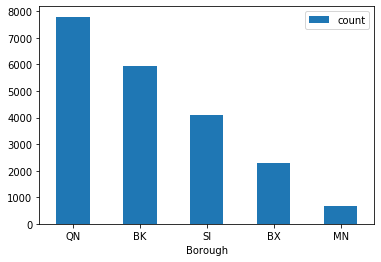

In [14]:
ax = boro_dist.plot.bar(x='Borough', y='count', rot=0)

In [15]:
difference_counts = df['difference'].value_counts()
difference_dist = pd.DataFrame({'difference':difference_counts.index, 'count':difference_counts.values})
difference_dist.sort_values(by='count', ascending=False, inplace=True)
difference_dist

,difference,count
0,1,15611
1,-1,3932
2,2,562
3,-2,234
4,3,139
5,4,69
6,-3,49
7,5,37
8,6,22
9,-4,16


In [16]:
difference_dist['difference'].describe()

count     58.000000
mean       4.775862
std       60.380386
min     -127.000000
25%      -15.500000
50%        0.000000
75%       14.750000
max      277.000000
Name: difference, dtype: float64

Text(0, 0.5, 'Frequency')

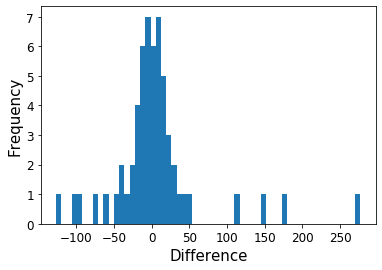

In [17]:
bins = difference_dist.shape[0]
difference_dist['difference'].hist(bins=bins, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Difference", fontsize=15)
plt.ylabel("Frequency",fontsize=15)

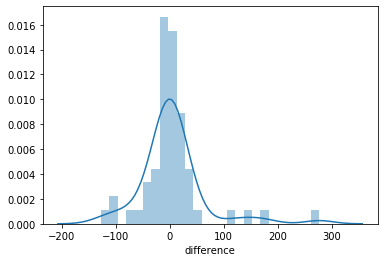

In [18]:
sns.distplot(difference_dist['difference'])

#### Assess changes by borough

What is the total number of buildings recorded on PLUTO today?

In [19]:
pluto["NumBldgs"].sum()

1105446.0

In [20]:
df["difference"].sum()

13592

In [24]:
pluto["NumBldgs"].sum() + df["difference"].sum()
pluto.head()

,BBL,Borough,NumBldgs
0,3008340046,BK,1.0
1,4040420106,QN,2.0
2,3046790017,BK,2.0
3,3078310006,BK,1.0
4,3078310007,BK,1.0


In [26]:
pluto = pd.merge(pluto, df[['BBL','difference']], how='left', left_on='BBL', right_on='BBL').fillna(0)
pluto.head()

,BBL,Borough,NumBldgs,difference
0,3008340046,BK,1.0,0.0
1,4040420106,QN,2.0,0.0
2,3046790017,BK,2.0,0.0
3,3078310006,BK,1.0,0.0
4,3078310007,BK,1.0,0.0


In [27]:
pluto['new_numbldgs'] = pluto['NumBldgs'] + pluto['difference']
pluto.head()

,BBL,Borough,NumBldgs,difference,new_numbldgs
0,3008340046,BK,1.0,0.0,1.0
1,4040420106,QN,2.0,0.0,2.0
2,3046790017,BK,2.0,0.0,2.0
3,3078310006,BK,1.0,0.0,1.0
4,3078310007,BK,1.0,0.0,1.0


In [28]:
borough_numbldgs = pluto.groupby(['Borough'])['NumBldgs'].agg('sum')
borough_numbldgs

Borough
BK    339232.0
BX    106878.0
MN     46582.0
QN    469165.0
SI    143589.0
Name: NumBldgs, dtype: float64

In [29]:
borough_new_numbldgs = pluto.groupby(['Borough'])['new_numbldgs'].agg('sum')
borough_new_numbldgs

Borough
BK    344319.0
BX    108105.0
MN     47117.0
QN    474707.0
SI    144790.0
Name: new_numbldgs, dtype: float64

In [31]:
borough_before_and_after = pd.merge(borough_numbldgs, borough_new_numbldgs, how='inner', on='Borough').fillna(0)
borough_before_and_after['difference'] = borough_before_and_after['new_numbldgs'] - borough_before_and_after['NumBldgs']
borough_before_and_after

,NumBldgs,new_numbldgs,difference
Borough,,,
BK,339232.0,344319.0,5087.0
BX,106878.0,108105.0,1227.0
MN,46582.0,47117.0,535.0
QN,469165.0,474707.0,5542.0
SI,143589.0,144790.0,1201.0
